## Zadání úlohy:

V této úloze použijeme PINN pro model situace nahřívání desky v jednom bodě (například pomocí laseru):

$$\begin{gather*}
    \frac{\partial u(x,\,y,\,t)}{\partial t} = \alpha^2 \cdot \Delta u(x,\,y,\,t) + h(x, y, t), \quad t\in[0, t_0]\\
    \frac{\partial u}{\partial n} = 0 \quad \text{ na } \partial \Omega
\end{gather*}$$

kde $\Omega = \{ (x, y) \in \mathbb{R}^2: |x| \leq 1 \land |y| \leq 1\}$, a
$$\begin{equation*}
    h(x, y, t) := 5 \exp{-100 * (x^2 + y^2)}
\end{equation*}$$

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# prvotni import

from typing import List
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
from numpy import pi
import matplotlib.pyplot as plt
sys.path.append('..')

In [60]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm

In [61]:
# volba device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
# definice ulohy
ALPHA = 114e-4  # diffusivity constant
A = 100
C = 5
T_0 = 10.0
l_bounds = [-1.0, -1.0, 0.0]  # lower bounds of the cube domain
u_bounds = [1.0, 1.0, T_0]

# trenovaci parametry
NAIVE_EPOCHS_ADAM = 1
NAIVE_EPOCHS_LBFGS = 1
CURRICULUM_EPOCHS_ADAM = 1
CURRICULUM_EPOCHS_LBFGS = 1
INTERIOR_SAMPLE_POINTS = 20_000
BOUNDARY_SAMPLE_POINTS = 1000
CENTER_SAMPLE_POINTS = 5000
SAVE_PATH = '../results/'

def heat_in(x: torch.Tensor) -> torch.Tensor:
    return C * torch.exp(-A * (x[:, 0:1]**2 + x[:, 1:2]**2))

In [63]:
# definice ztratovych funkci

def compute_residuum(input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    output = model(input)
    laplacian = calc.laplacian(input, output, device=device)
    u_t = grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0][:, -1:]
    h_vals = heat_in(input)
    return u_t - ALPHA * laplacian - h_vals


def loss_interior(input: torch.Tensor, model: torch.nn.Module):
    residuum = compute_residuum(input, model)
    return torch.mean(residuum ** 2)


def neumann_bounday(input: torch.Tensor, model: torch.nn.Module, normal: torch.Tensor):
    output = model(input)
    u_n = calc.dir_derivative(input, output, normal, True, True)
    return torch.mean(u_n ** 2)


def loss_init(input: torch.Tensor, model: torch.nn.Module):
    output = model(input)
    init_vals = init_temp(input)
    return torch.mean((output - init_vals) ** 2)

left_condition = torch.tensor([])
first_iteration = True

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain):
    # interior loss
    interior_input = domain.interior.requires_grad_(True)
    loss_int = loss_interior(interior_input, model)

    # pocatecni ztrata
    if first_iteration:
        init_input = domain.sides[-1][0].requires_grad_(True)
        loss_init_val = loss_init(init_input, model)
    else:
        output_init = model(domain.sides[-1][0])
        loss_init_val = torch.mean((output_init - left_condition) ** 2)

    # neumann ztrata
    # leva hranice
    input_left = domain.sides[0][0].requires_grad_(True)
    loss_neumann_left = neumann_bounday(input_left, model, normal=torch.tensor([-1.0, 0.0],device=device,requires_grad=True))
    # prava hranice
    input_right = domain.sides[0][1].requires_grad_(True)
    loss_neumann_right = neumann_bounday(input_right, model, normal=torch.tensor([1.0, 0.0],device=device,requires_grad=True))
    # horni hranice
    input_top = domain.sides[1][0].requires_grad_(True)
    loss_neumann_top = neumann_bounday(input_top, model, normal=torch.tensor([0.0, 1.0],device=device,requires_grad=True))
    # dolni hranice
    input_bottom = domain.sides[1][1].requires_grad_(True)
    loss_neumann_bottom = neumann_bounday(input_bottom, model, normal=torch.tensor([0.0, -1.0],device=device,requires_grad=True))

    side_loss = loss_neumann_left + loss_neumann_right + loss_neumann_top + loss_neumann_bottom

    return [loss_int, loss_init_val, side_loss]

In [64]:
model_naive_ctx = mm.ModelContext(
    input_dim=3,
    output_dim=1,
    layer=[64, 64, 64, 64],
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    last_layer_activation='tanh'
)

model_naive = mm.MLPModel(model_naive_ctx).to(device)

model_curriculum = mm.MLPModel(model_naive_ctx).to(device)

optimizer_naive = torch.optim.Adam(model_naive.parameters(), lr=1e-3)
optimizer_curriculum = torch.optim.Adam(model_curriculum.parameters(), lr=1e-3)

scheduler_naive = ReduceLROnPlateau(optimizer_naive, factor=0.75, patience=300)
scheduler_curriculum = ReduceLROnPlateau(optimizer_curriculum, factor=0.5, patience=100)

In [65]:
cube_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    N_int=INTERIOR_SAMPLE_POINTS,
    N_sides=3 * [[BOUNDARY_SAMPLE_POINTS, BOUNDARY_SAMPLE_POINTS]],
    dim=3,
    device=device,
    int_sampling='Biased',
    bias_pts=[(torch.tensor([0, 0], device=device), CENTER_SAMPLE_POINTS, 0.4)],
)

domain = cb.CubeDomain(cube_ctx)

In [66]:
# Prvne naivni zpusob
train_naive_ctx = train.TrainingContext(
    model=model_naive,
    domain=domain,
    loss_fn=loss_fn,
    optimizer=optimizer_naive,
    epochs=NAIVE_EPOCHS_ADAM,
    resample_freq=100,
    resample=True,
    scheduler=scheduler_naive,
    monitor_lr=True
)

domain.generate_points()
naive_loss_vals, naive_loss_vals_per_comp = train.train_switch_to_lbfgs(train_naive_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=NAIVE_EPOCHS_LBFGS)

Loss at epoch 1 is: 0.20432454347610474. Current learing rate: 0.001 
Switching to LBFGS


In [67]:
# Dale zkusime curriculum strategii

tratin_curriculum_ctx = train.TrainingContext(
    model=model_curriculum,
    domain=domain,
    loss_fn=loss_fn,
    optimizer=optimizer_curriculum,
    epochs=CURRICULUM_EPOCHS_ADAM,
    scheduler=None    
)


# prvni iterace
domain.ctx.l_bounds = [-1.0, -1.0, 0.0]
domain.ctx.u_bounds = [1.0, 1.0, 1.0]
first_iteration = True
total_curr_loss, _ = train.train_switch_to_lbfgs(tratin_curriculum_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=CURRICULUM_EPOCHS_LBFGS)

DELTA_TS = [2.0, 3.0, 4.0, 5.0]
for delta_t in DELTA_TS:
    # posunuti domeny
    print(f"Training in interval: [0, {float(delta_t)}]")
    domain.ctx.u_bounds = [1.0, 1.0, delta_t]
    # nastaveni nove pocatecni podminky

    # trenovani v novem casovem useku
    new_total_curr_loss, _ = train.train_switch_to_lbfgs(tratin_curriculum_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=CURRICULUM_EPOCHS_LBFGS)
    total_curr_loss += new_total_curr_loss

Loss at epoch 1 is: 0.224114328622818. 
Switching to LBFGS
Training in interval: [0, 2.0]
Loss at epoch 1 is: 0.2202146351337433. 
Switching to LBFGS
Training in interval: [0, 3.0]
Loss at epoch 1 is: 0.20462168753147125. 
Switching to LBFGS
Training in interval: [0, 4.0]
Loss at epoch 1 is: 0.20477353036403656. 
Switching to LBFGS
Training in interval: [0, 5.0]
Loss at epoch 1 is: 0.21410903334617615. 
Switching to LBFGS


/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


FileNotFoundError: [Errno 2] No such file or directory: '../results/loss.png'

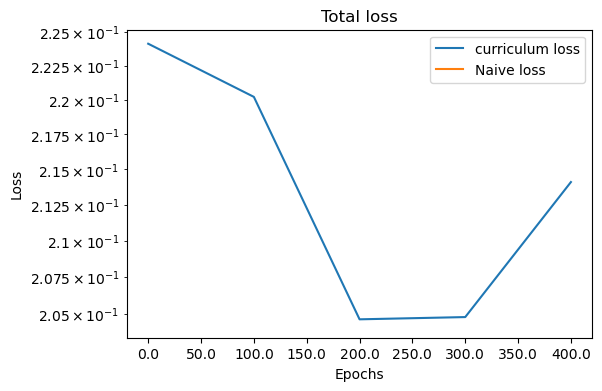

In [68]:
plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    device=device,
    patches=[],
    colour_map='inferno',
    vmin=0,
    vmax=4,
    N=100,
    x_label="Epochs",
    y_label="Loss",
    titles=["Total loss"],
    save_img=True,
    save_path=SAVE_PATH + 'loss.png'
)

utils.plot_loss_values({'curriculum loss': total_curr_loss, 'Naive loss': naive_loss_vals}, plot_ctx)

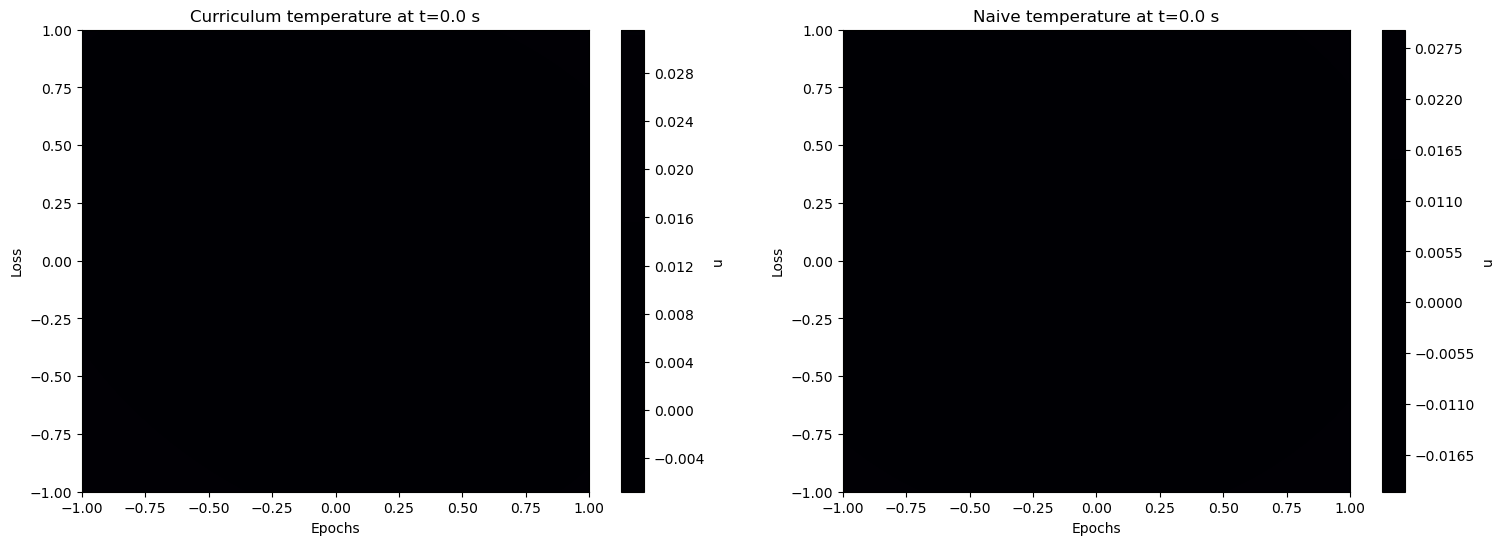

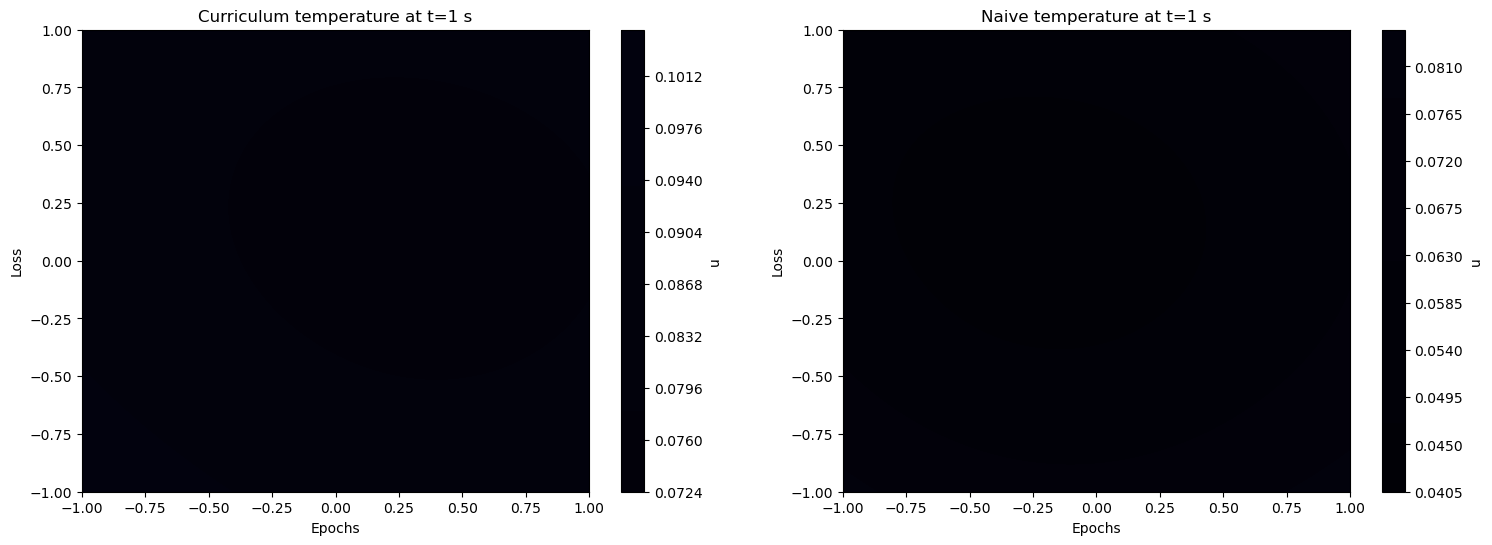

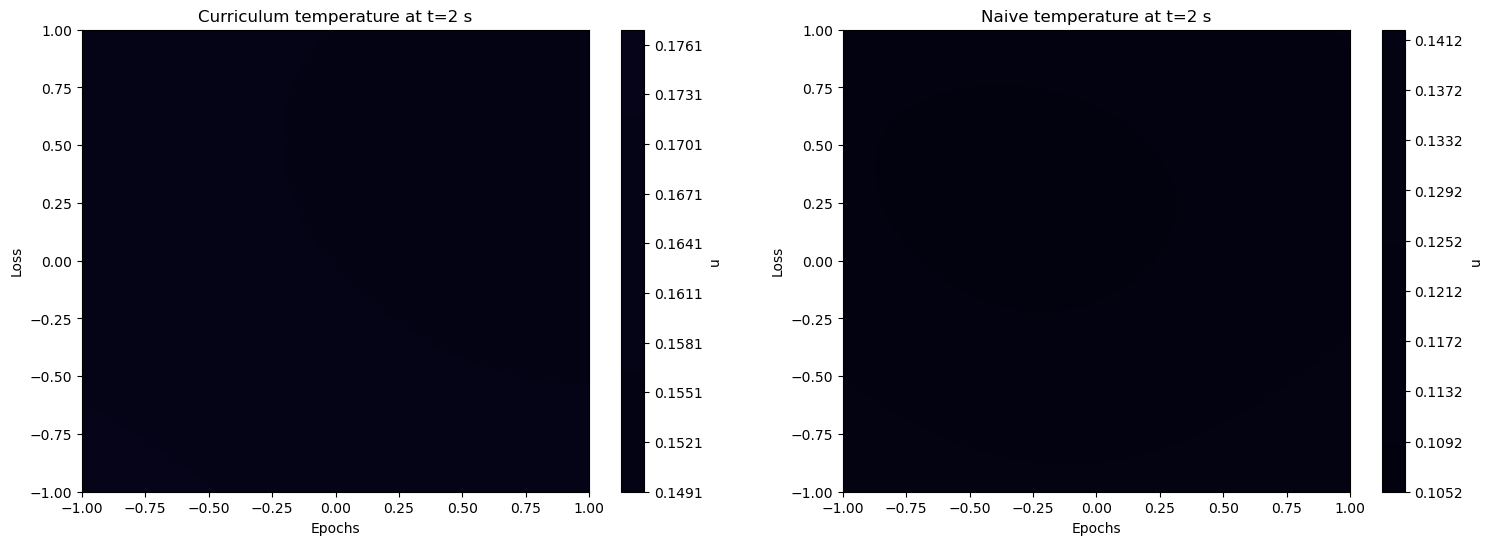

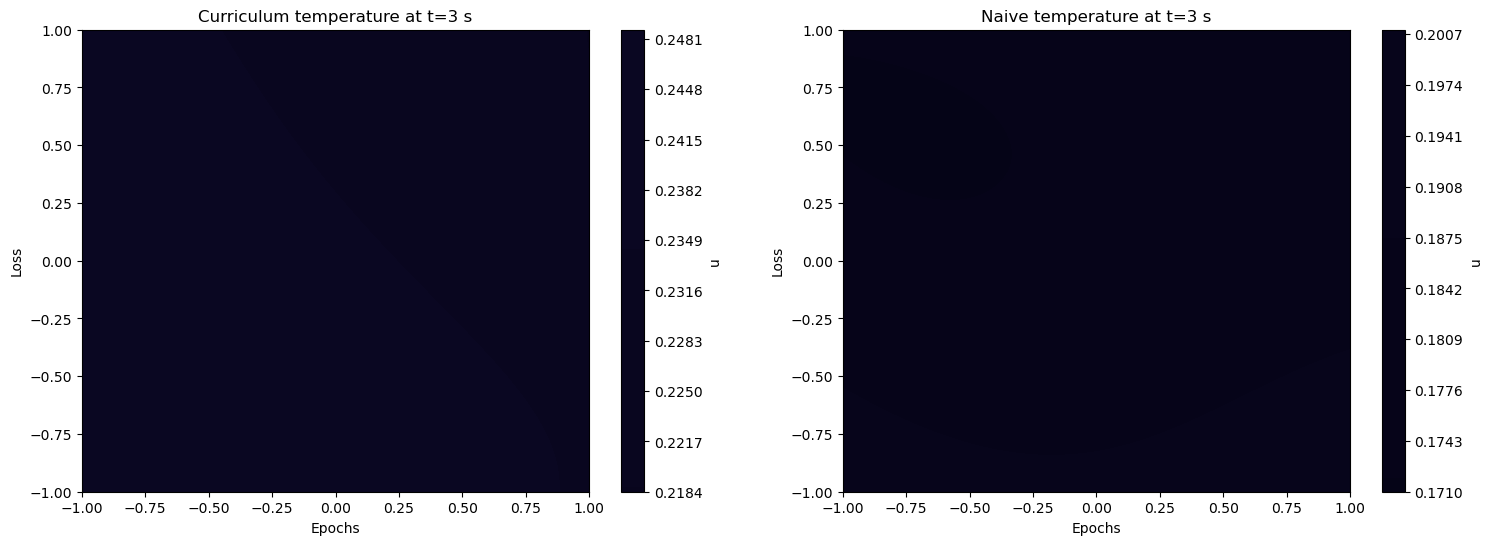

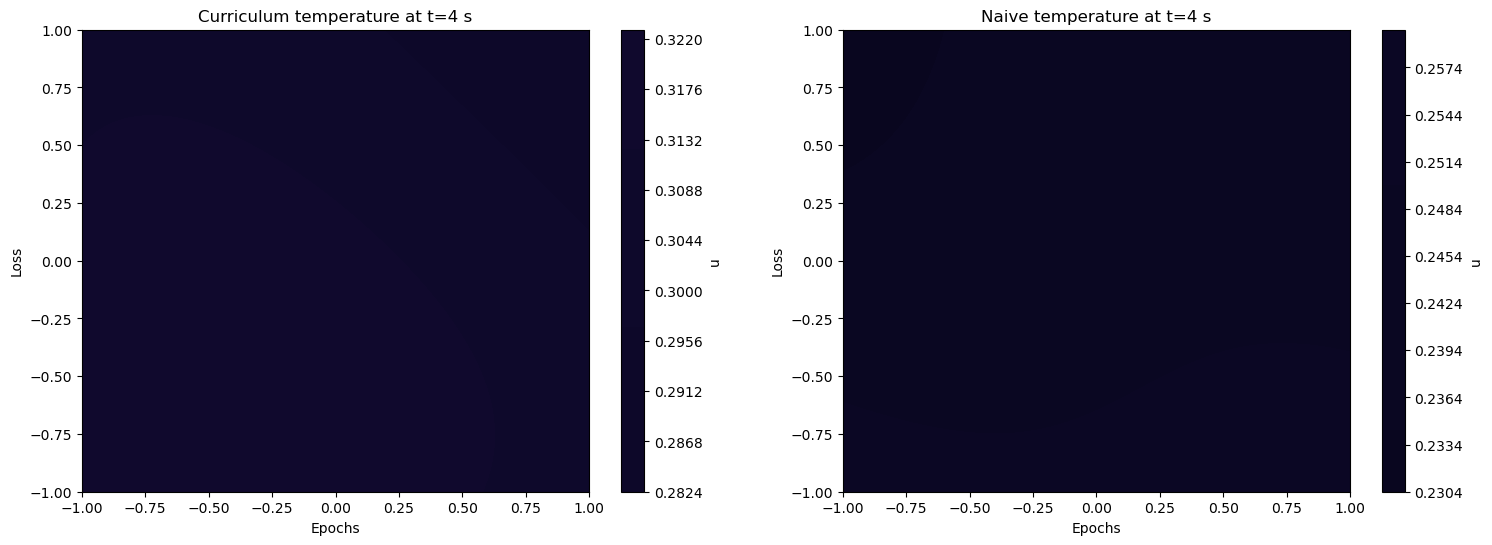

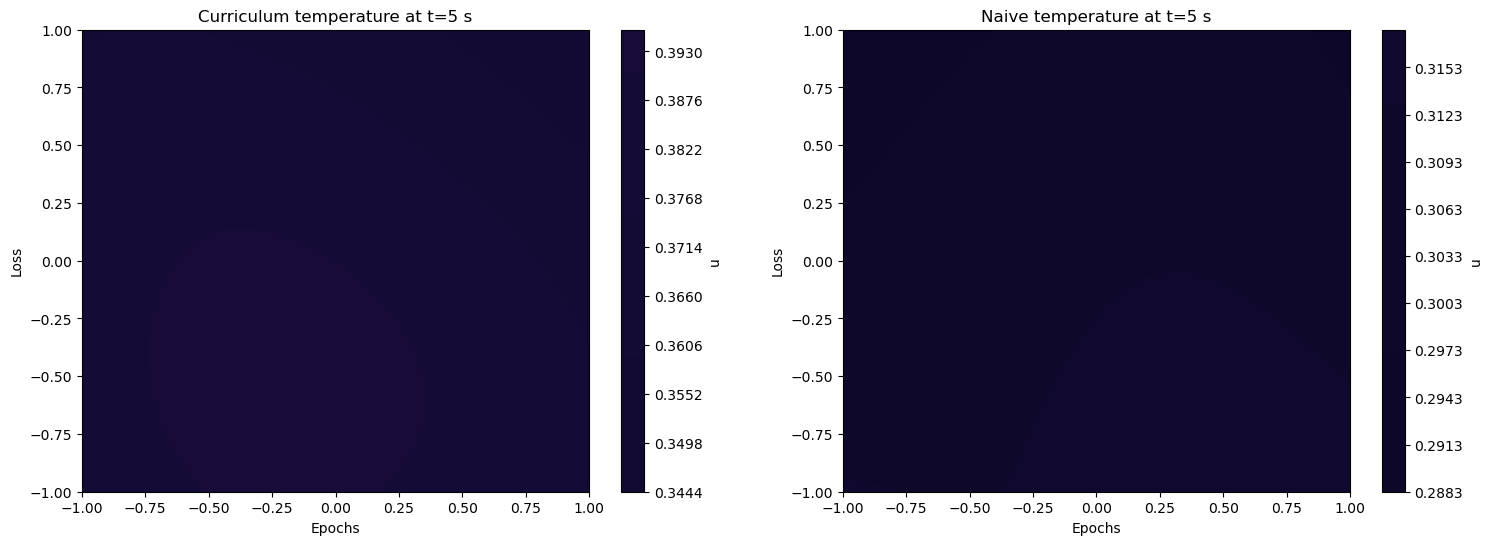

In [ ]:
# vykresleni vysledku

t = 0
plot_ctx.figsize = (18, 6)

def s2s_u_t(input: torch.Tensor) -> torch.Tensor:
    time = torch.full_like(input[:, 0:1], t, device=device)
    return model_curriculum(torch.cat((input, time), dim=1))

def naive_u_t(input: torch.Tensor) -> torch.Tensor:
    time = torch.full_like(input[:, 0:1], t, device=device)
    return model_naive(torch.cat((input, time), dim=1))

plot_ctx.function_names = ['u', 'u']

for t in [0.0, 1, 2, 3, 4, 5]:
    plot_ctx.titles = [f"Curriculum temperature at t={t} s", f"Naive temperature at t={t} s"]
    plot_ctx.save_path = SAVE_PATH + f'temp_at_t_{t}.png'
    utils.plot_function_on_2d_cube([s2s_u_t, naive_u_t], plot_ctx)

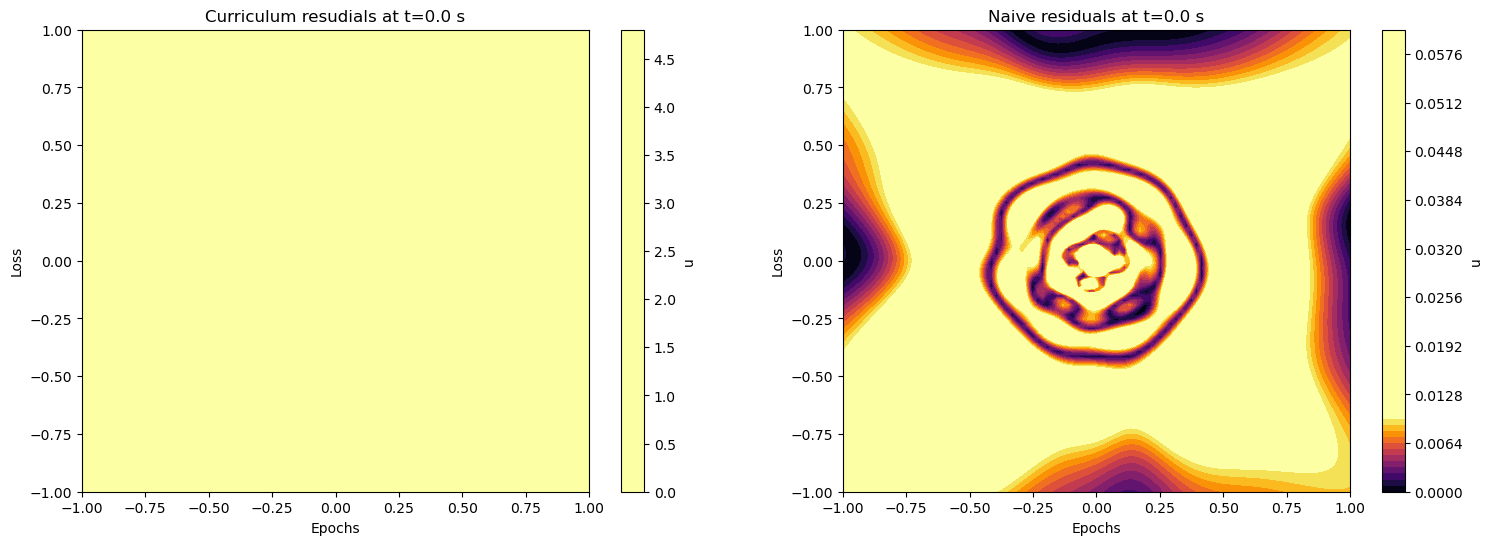

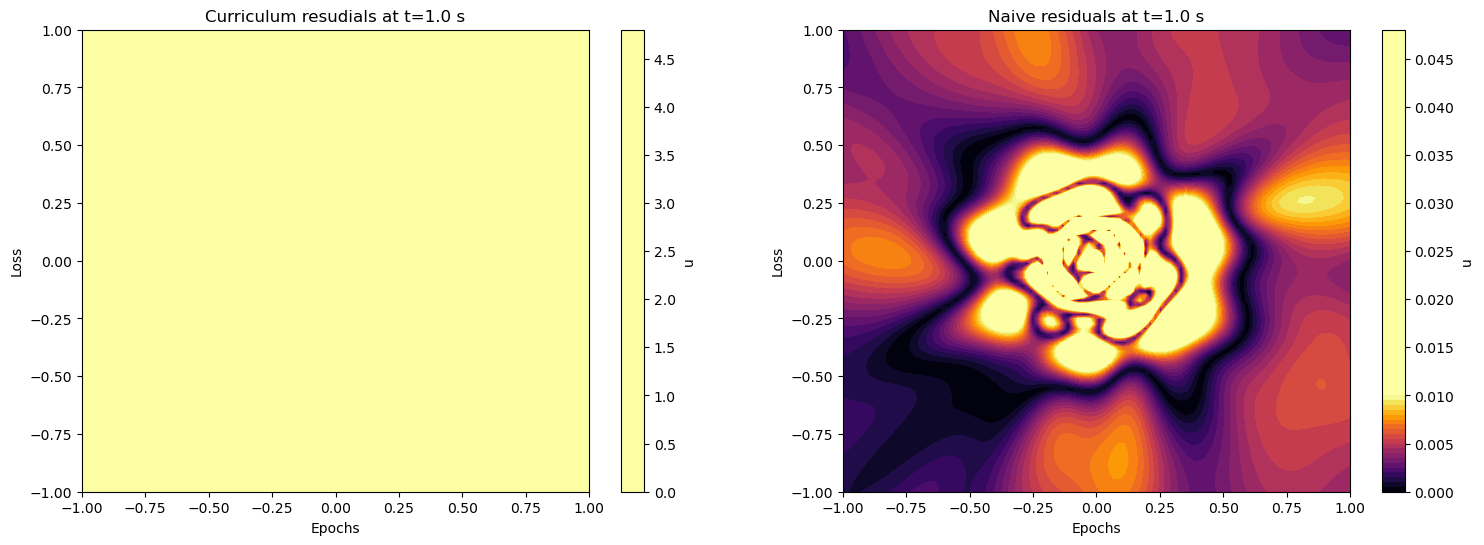

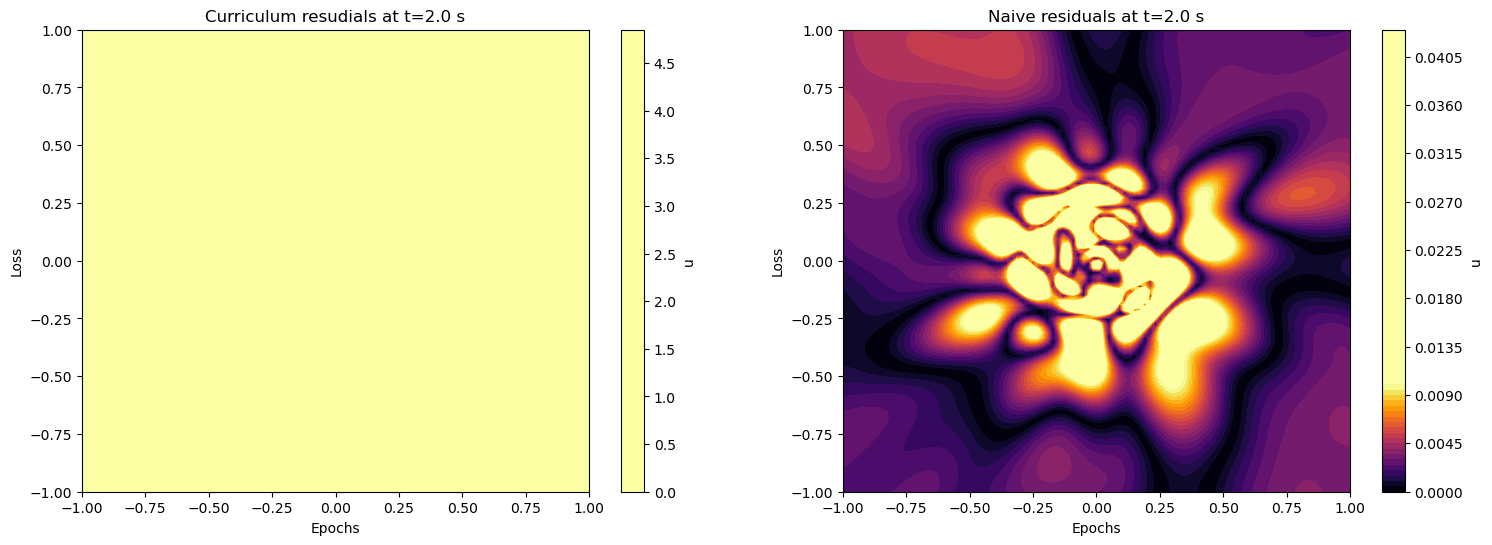

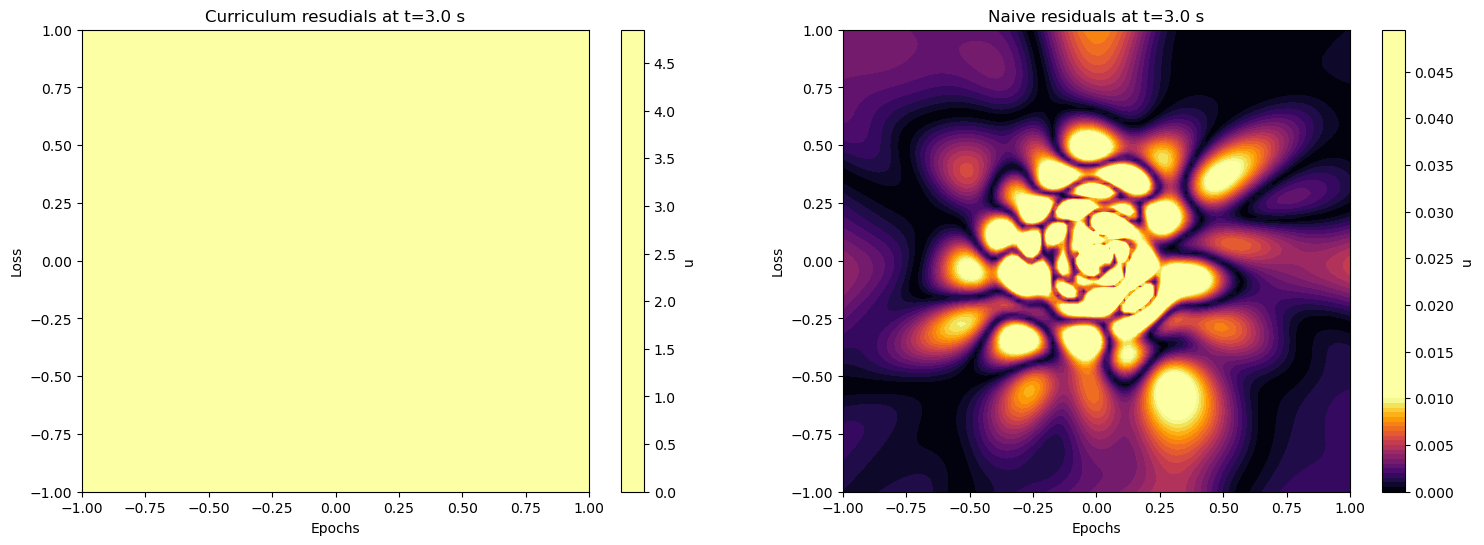

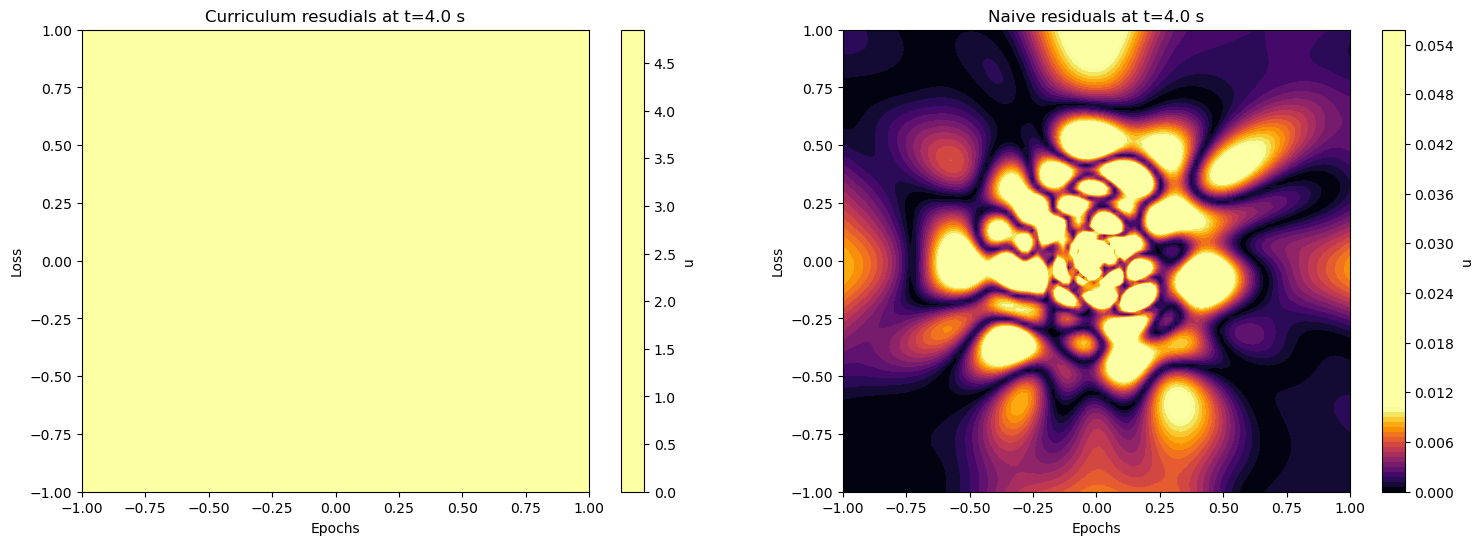

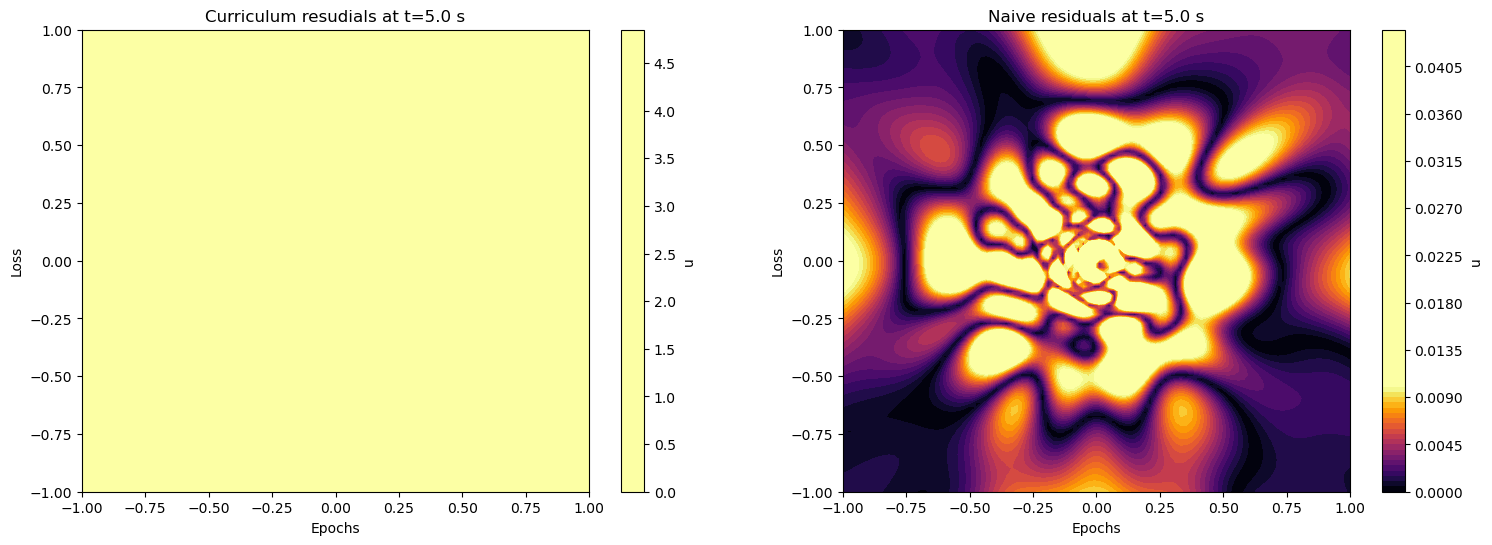

In [ ]:
def residual_at(input: torch.Tensor, time: float, model: torch.nn.Module) -> torch.Tensor:
    time_tensor = torch.full((input.shape[0], 1), time, device=device)
    full_input = torch.cat([input, time_tensor], dim=1).requires_grad_(True)

    res = compute_residuum(full_input, model=model)
    return torch.abs(res)

plot_ctx.vmin=0
plot_ctx.vmax = 0.01

for t in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:
    plot_ctx.save_path = SAVE_PATH + f'residuum_at_t_{t}.png'
    plot_ctx.titles = [f"Curriculum resudials at t={t} s", f"Naive residuals at t={t} s"]
    utils.plot_function_on_2d_cube([lambda x: residual_at(x, t, model_curriculum),
                                    lambda x: residual_at(x, t, model_naive)], plot_ctx)